
# Correlation across Ensembles


Purpose:
- Quantify redundancy and complementarity across intermediate representations.
- Show per–pair correlation matrices and an average across pairs.
- Fix the time window resolution to **1.0 s** to avoid trivial correlations introduced by aggregating different durations of the same event stream.

Notes:
- We correlate **raw similarity matrices** with **no sequence matching**.
- Each matrix corresponds to a triplet: **reconstruction | feature extractor | time_res**.
- The plotted heatmaps are **triangular** (upper triangle), omitting the diagonal and duplicate half for compactness.
- This notebook is intended for GitHub as supplemental material due to limited paper space.


In [2]:

# --- Configuration ---
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Fix time resolution at 1.0 as discussed
TIME_RESOLUTIONS = [1.0]

# Choose your dataset/bin settings (edit to match your project structure)
DATASET_ROOT = "../data"                # base for image_reconstructions
BIN_NAME = "fixed_timebins"             # must match how files were generated
MODE = "frame"                          # 'frame' or 'patch'

# Methods to compare
RECON_METHODS = ['timeSurface', 'e2vid', 'eventCount', 'eventCount_noPolarity']
VPR_FEATURE_EXTRACTORS = ['mixvpr', 'megaloc', 'cosplace', 'netvlad']

# Ref–Qry pairs to include in the analysis
REF_QRY_PAIRS = [
    ('Brisbane', 'sunset1', 'night'),
    ('Brisbane', 'sunset1', 'morning'),
    ('Brisbane', 'sunset1', 'sunrise'),
    ('Brisbane', 'sunset1', 'sunset2'),
    ('Brisbane', 'sunset1', 'daytime'),
    ('NSAVP', 'R0_FA0', 'R0_FS0'),
    ('NSAVP', 'R0_FA0', 'R0_FN0'),
    ('NSAVP', 'R0_FN0', 'R0_FS0'),
    ('NSAVP', 'R0_RS0', 'R0_RN0'),
    ('NSAVP', 'R0_RA0', 'R0_RN0'),
]

print(f"Pairs: {len(REF_QRY_PAIRS)} | Recon methods: {len(RECON_METHODS)} | Extractors: {len(VPR_FEATURE_EXTRACTORS)} | time_res fixed at 1.0")


Pairs: 10 | Recon methods: 4 | Extractors: 4 | time_res fixed at 1.0


In [3]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
# ---------- core loaders (no sequence matching) ----------
def load_raw_similarity_matrix(
    dataset_name,
    bin_name,
    ref_name,
    qry_name,
    recon_method,
    vpr_method,
    time_str,
    mode='frame',
):
    """
    Loads the raw similarity matrix (no sequence matching)
    """

    base_dir = Path(f"logs/{dataset_name}/{bin_name}_{time_str}/")
    time_str_simmat = time_str if bin_name.startswith('fixed') else 'None'
    filename = f"{ref_name}_vs_{qry_name}_{vpr_method}_l2_reconstruct_{recon_method}_{time_str_simmat}_{mode}_1_1.npy"
    file_path = base_dir / filename

    sim_matrix = np.load(file_path)


    return sim_matrix

# ---------- correlation helpers ----------
def _flatten_finite(M):
    v = np.asarray(M, dtype=float).ravel()
    m = np.isfinite(v)
    return v[m]

def _corr_matrix_from_mats(mats, labels, corr_type='pearson'):
    K = len(mats)
    corr = np.eye(K, dtype=float)
    flats = [_flatten_finite(m) for m in mats]

    for i in range(K):
        ai = flats[i]
        for j in range(i+1, K):
            bj = flats[j]
            n = min(len(ai), len(bj))
            if n == 0:
                val = np.nan
            else:
                a = ai[:n]
                b = bj[:n]
                if corr_type == 'spearman':
                    from scipy.stats import spearmanr
                    val, _ = spearmanr(a, b)
                else:
                    a = a - a.mean()
                    b = b - b.mean()
                    denom = np.linalg.norm(a) * np.linalg.norm(b)
                    val = (a @ b) / denom if denom > 0 else np.nan
            corr[i, j] = corr[j, i] = val
    return corr




## Per-pair correlation matrices

For each pair we compute a correlation matrix across all combinations of reconstruction × feature extractor at time_res = 1.0.
The diagonal is removed in the visualization. Higher correlations indicate representations that induce similar similarity structures and may be redundant. Lower correlations indicate complementary information that can benefit ensembles.


Computing: Brisbane sunset1 vs night
Computing: Brisbane sunset1 vs morning
Computing: Brisbane sunset1 vs sunrise
Computing: Brisbane sunset1 vs sunset2
Computing: Brisbane sunset1 vs daytime
Computing: NSAVP R0_FA0 vs R0_FS0
Computing: NSAVP R0_FA0 vs R0_FN0
Computing: NSAVP R0_FN0 vs R0_FS0
Computing: NSAVP R0_RS0 vs R0_RN0
Computing: NSAVP R0_RA0 vs R0_RN0


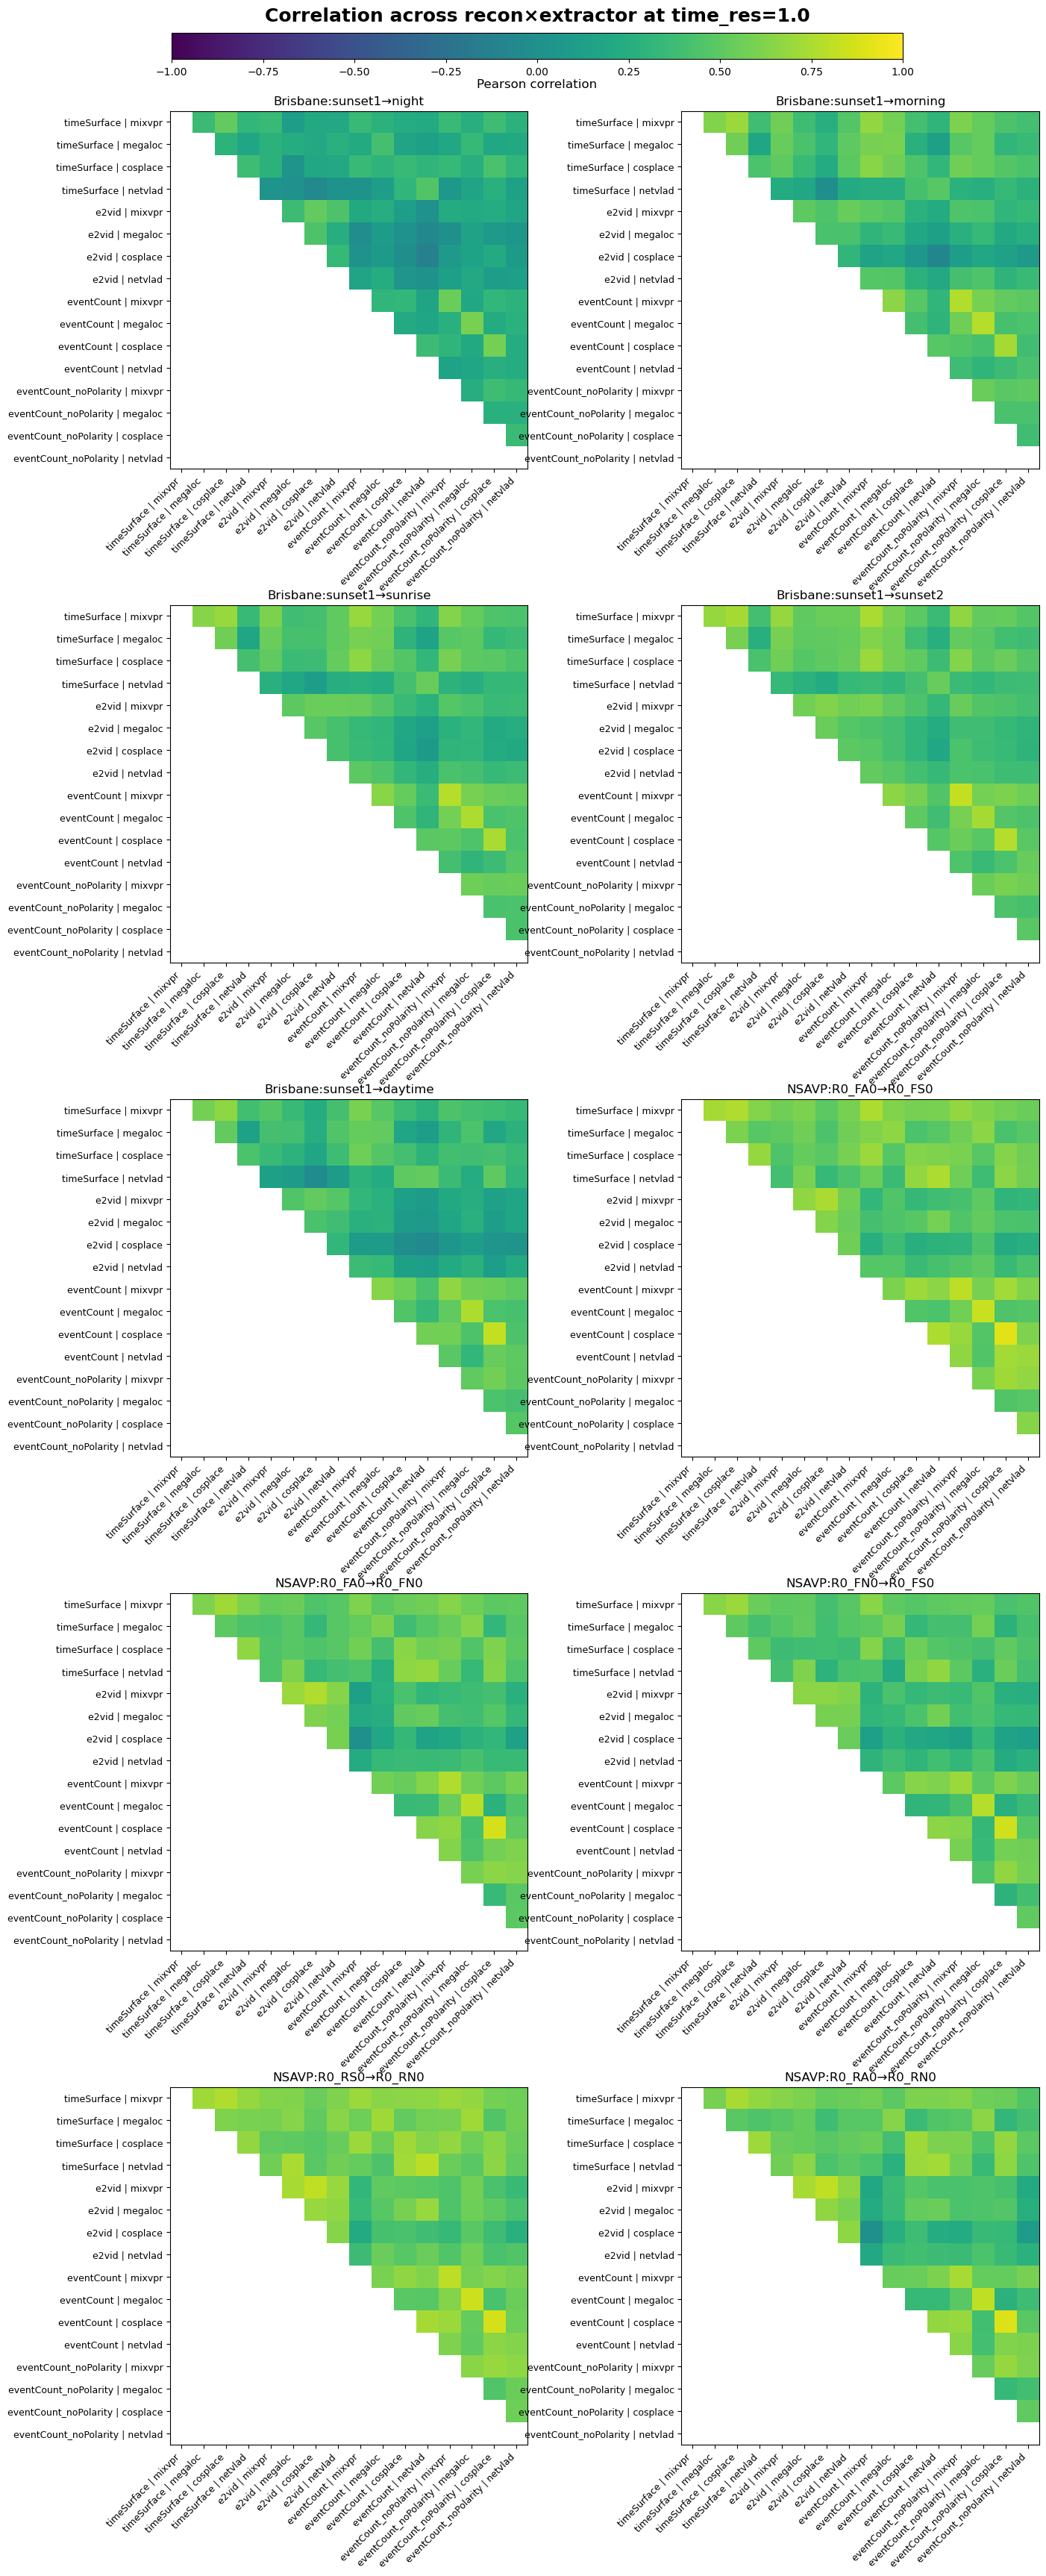

In [4]:

def corr_for_pair(dataset_name, ref_name, qry_name,
                  bin_name, recon_methods, vpr_extractors, time_res='1.0',
                  mode='frame', corr_type='pearson'):
    mats = []
    labels = []
    for recon in recon_methods:
        for vpr in vpr_extractors:
            sim = load_raw_similarity_matrix(
                dataset_name=dataset_name, bin_name=bin_name,
                ref_name=ref_name, qry_name=qry_name,
                recon_method=recon, vpr_method=vpr,
                time_str=str(time_res), mode=mode
            )
            mats.append(sim)
            labels.append(f"{recon} | {vpr}")
    C = _corr_matrix_from_mats(mats, labels, corr_type=corr_type)
    return C, labels

import matplotlib.pyplot as plt
import numpy as np

# helper: draw a triangular heatmap into a provided Axes (no colorbar)
def _draw_tri_heatmap_ax(ax, M, labels, title,
                         triangle='upper', vmin=-1.0, vmax=1.0, annotate=False):
    M = np.asarray(M, dtype=float)
    n = M.shape[0]
    assert M.shape[1] == n and len(labels) == n

    M_plot = M.copy()
    if triangle == 'upper':
        mask = np.tril_indices(n, k=0)   # hide diagonal and lower
    else:
        mask = np.triu_indices(n, k=0)   # hide diagonal and upper
    M_plot[mask] = np.nan

    cmap = plt.cm.viridis.copy()
    cmap.set_bad(alpha=0.0)

    im = ax.imshow(M_plot, aspect='equal', vmin=vmin, vmax=vmax,
                   cmap=cmap, interpolation='nearest')
    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(labels, fontsize=8)
    ax.set_title(title, fontsize=10)

    if annotate:
        for i in range(n):
            for j in range(n):
                if (triangle == 'upper' and i < j) or (triangle == 'lower' and i > j):
                    val = M[i, j]
                    if np.isfinite(val):
                        ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=7)
    return im

# compute and collect correlations first (as you already do)
pair_corrs = []
pair_titles = []
labels_for_axes = None

for (dset, ref_name, qry_name) in REF_QRY_PAIRS:
    print(f"Computing: {dset} {ref_name} vs {qry_name}")
    C, labels = corr_for_pair(
        dataset_name=dset, ref_name=ref_name, qry_name=qry_name,
        bin_name=BIN_NAME, recon_methods=RECON_METHODS,
        vpr_extractors=VPR_FEATURE_EXTRACTORS, time_res='1.0',
        mode=MODE, corr_type='pearson'
    )
    pair_corrs.append(C)
    pair_titles.append(f"{dset}:{ref_name}→{qry_name}")
    if labels_for_axes is None:
        labels_for_axes = labels  # same order for all

# plot 3x4 grid
rows, cols = 5, 2
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*7))
axes = np.atleast_2d(axes)

vmin, vmax = -1.0, 1.0  # Pearson corr range
last_im = None
for idx, (C, ttl) in enumerate(zip(pair_corrs, pair_titles)):
    r, c = divmod(idx, cols)
    ax = axes[r, c]
    last_im = _draw_tri_heatmap_ax(ax, C, labels_for_axes, ttl,
                                   triangle='upper', vmin=vmin, vmax=vmax, annotate=False)

# turn off unused subplots
for k in range(len(pair_corrs), rows*cols):
    r, c = divmod(k, cols)
    axes[r, c].axis('off')

# shared colorbar
from matplotlib.cm import ScalarMappable

# after creating fig/axes and drawing the subplots:
vmin, vmax = -1.0, 1.0
sm = ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])

# reserve space for title + top colorbar
plt.tight_layout(rect=[0, 0, 1, 0.95])   # push content down a bit
fig.suptitle("Correlation across recon×extractor at time_res=1.0", y=0.98, fontsize=18, weight='bold')

# increase title / tick font sizes for all subplots
for ax in axes.ravel():
    ax.title.set_fontsize(12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    for lbl in ax.get_xticklabels():
        lbl.set_fontsize(9)
    for lbl in ax.get_yticklabels():
        lbl.set_fontsize(9)

# make the colorbar label larger when created later
plt.rcParams.update({'axes.labelsize': 12, 'font.size': 10})

# add a horizontal colorbar axis just below the title
cb_ax = fig.add_axes([0.15, 0.96, 0.70, 0.01])  # [left, bottom, width, height] in figure coords
cbar = fig.colorbar(sm, cax=cb_ax, orientation='horizontal')
cbar.set_label('Pearson correlation', labelpad=2)


plt.show()



## Average correlation matrix across pairs

We compute an elementwise average of the per-pair correlation matrices to summarize redundancy/complementarity trends across all routes. NaNs are ignored in the average.


Average correlation shape: (16, 16)


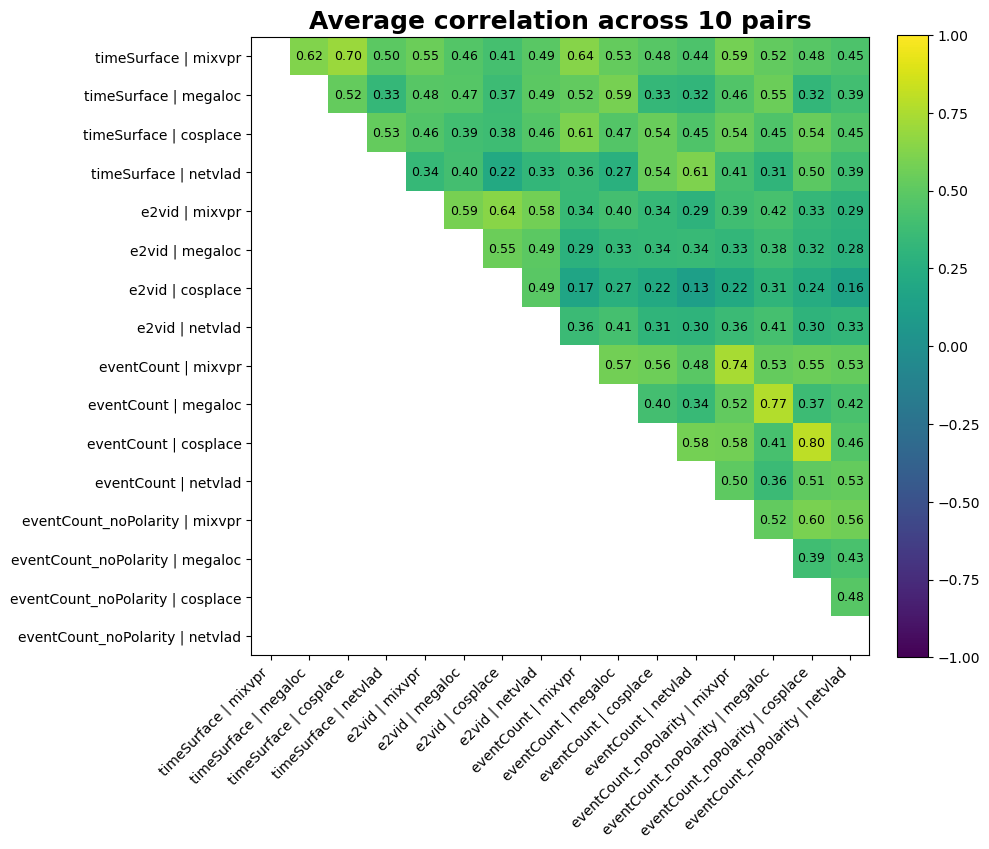

In [13]:

import numpy as np

def _plot_heatmap_tri(
    M, labels, title,
    save_path=None, vmin=-1.0, vmax=1.0,
    triangle='upper'  # 'upper' or 'lower'
):
    """
    Plot only one triangle of a symmetric matrix (no diagonal).
    triangle='upper' shows i<j entries; 'lower' shows i>j entries.
    """
    M = np.asarray(M, dtype=float)
    n = M.shape[0]
    assert M.shape[1] == n, "M must be square"
    assert len(labels) == n, "labels length must match M"

    # Mask the unwanted half and the diagonal
    M_plot = M.copy()
    if triangle == 'upper':
        mask_idx = np.tril_indices(n, k=0)   # diagonal and below
    else:
        mask_idx = np.triu_indices(n, k=0)   # diagonal and above
    M_plot[mask_idx] = np.nan

    # Make NaNs transparent
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(alpha=0.0)

    fig, ax = plt.subplots(figsize=(0.5*n + 2, 0.5*n + 2))
    im = ax.imshow(M_plot, aspect='equal', vmin=vmin, vmax=vmax,
                   cmap=cmap, interpolation='nearest')

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)
    ax.set_title(title, fontsize=18, fontweight='bold')
    

    # Annotate only visible half (no diagonal)
    for i in range(n):
        for j in range(n):
            if (triangle == 'upper' and i < j) or (triangle == 'lower' and i > j):
                val = M[i, j]
                if np.isfinite(val):
                    ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=9)

    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300)
    plt.show()



# Stack and average (ignore NaNs just in case)
stacked = np.stack([np.where(np.isfinite(C), C, np.nan) for C in pair_corrs], axis=0)
avg_corr = np.nanmean(stacked, axis=0)

print("Average correlation shape:", avg_corr.shape)

# Use same labels as any pair (all are aligned by construction)
labels = [f"{recon} | {vpr}" for recon in RECON_METHODS for vpr in VPR_FEATURE_EXTRACTORS]

_plot_heatmap_tri(avg_corr, labels,
                 title=f"Average correlation across {len(pair_corrs)} pairs", 
                 save_path="plots/average_correlation_heatmap.pdf")



## Interpretation notes

- **What is being correlated?** Each entry corresponds to the Pearson correlation between two raw similarity matrices. This measures how similarly two representations rank database candidates for the same queries.
- **Diagonal omitted:** The diagonal is 1.0 by definition and is hidden to focus on cross-representation relationships.
- **High correlation (e.g., ≥ 0.7):** Likely redundant for ensembling.
- **Moderate correlation (≈ 0.3–0.6):** Partially complementary; ensembling can help.
- **Low correlation (≤ 0.2):** Highly complementary; strongest candidates to combine.
- **Design choice:** Time resolution fixed to 1.0 s to avoid trivial correlations induced by re-aggregating the same events at different durations.
- **Caveat:** Correlation does not directly equal ensemble gain; it is a proxy. We still evaluate retrieval quality separately. This view helps explain why certain ensembles help (orthogonal signals) or saturate (redundancy).
